In this notebook, we will learn what are choropleth maps and how to build them using `geopandas` and `folium`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import folium

A choropleth is a thematic map that uses color to compare regions. We will use the `schools_in_districts` to create a normalized value `school_density` to use for plotting a choropleth in which a region with a higher value is colored in a darker shade of color.

In [4]:
schools = pd.read_csv("assets/schools.csv")

schools["geometry"] = schools.apply(lambda row: Point((row.Longitude, row.Latitude)), axis = 1)

schools_gpd = gpd.GeoDataFrame(schools[["School Name", "geometry"]], geometry = "geometry", crs = "epsg:4326")

school_dists = gpd.read_file("assets/school-district.geojson")

schools_in_districts = gpd.sjoin(
    schools_gpd,
    school_dists,
    predicate = "within"
)

schools_in_districts.head(5)

C:\Users\U\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


,School Name,geometry,index_right,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone
0,A. Z. Kelley Elementary,POINT (-86.65885 36.02182),7,Tyese,Antioch,37013,tyese.hunter@mnps.org,TN,Hunter,2433 Evanfield Court,Member,2018,6,615-739-8068
4,Antioch High School,POINT (-86.59942 36.04667),7,Tyese,Antioch,37013,tyese.hunter@mnps.org,TN,Hunter,2433 Evanfield Court,Member,2018,6,615-739-8068
5,Antioch Middle,POINT (-86.67183 36.05538),7,Tyese,Antioch,37013,tyese.hunter@mnps.org,TN,Hunter,2433 Evanfield Court,Member,2018,6,615-739-8068
6,Apollo Middle,POINT (-86.66407 36.06688),7,Tyese,Antioch,37013,tyese.hunter@mnps.org,TN,Hunter,2433 Evanfield Court,Member,2018,6,615-739-8068
12,Cambridge Early Learning Center,POINT (-86.64102 36.06035),7,Tyese,Antioch,37013,tyese.hunter@mnps.org,TN,Hunter,2433 Evanfield Court,Member,2018,6,615-739-8068


We can get the number of schools in each district by groupping by the `district` column and aggregating by count.

In [67]:
schools_count = schools_in_districts[["district", "School Name"]].groupby(["district"]).agg("count")

schools_count = schools_count.reset_index().rename(columns = {"School Name" : "schools_count"})

districts_with_counts = pd.merge(school_dists, schools_count, on = "district")

districts_with_counts

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry,schools_count
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...",30
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ...",19
2,Dr. Jo Ann,Nashville,37220,joann.brannon@mnps.org,TN,Brannon,5444 San Marcos Drive,Member,2018,2,615-833-5976,"MULTIPOLYGON (((-86.76696 36.08333, -86.76590 ...",11
3,Anna,Hermitage,37076,anna.shepherd@mnps.org,TN,Shepherd,4545 Raccoon Trail,Chair,2018,4,615-210-3768,"MULTIPOLYGON (((-86.58098 36.20935, -86.58099 ...",18
4,Amy,Nashville,37221,amy.frogge@mnps.org,TN,Frogge,7237 Riverfront Drive,Member,2016,9,615-521-5650,"MULTIPOLYGON (((-86.97287 36.20828, -86.97045 ...",12
5,Mary,Nashville,37215,mary@pierceforschools.org,TN,Pierce,4329 Wallace Lane,Member,2018,8,615-310-9772,"MULTIPOLYGON (((-86.80849 36.14744, -86.80863 ...",10
6,Christine,Nashville,37203,cbuggs@mnps.org,TN,Buggs,425 Fisk Street,Member,2016,5,615-525-5371,"MULTIPOLYGON (((-86.69728 36.20414, -86.69696 ...",36
7,Tyese,Antioch,37013,tyese.hunter@mnps.org,TN,Hunter,2433 Evanfield Court,Member,2018,6,615-739-8068,"MULTIPOLYGON (((-86.70559 36.09685, -86.70306 ...",21
8,Will,Nashville,37204,will@pinkstonforschools.com,TN,Pinkston,937 Battlefield Drive,Member,2016,7,615-298-5787,"MULTIPOLYGON (((-86.55811 36.13984, -86.55812 ...",13


To normalize the count, we will divide the count by the area of each district. Of course, we can get the are of each district using `schools_dists.geometry.area`

In [68]:
districts_with_counts["area_km2"] = districts_with_counts.to_crs(epsg=3857).geometry.area / (10**6)

districts_with_counts["school_density_per_km2"] = districts_with_counts.apply(lambda row : row.schools_count / row.area_km2, axis = 1)

districts_with_counts.head(2)

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry,schools_count,area_km2,school_density_per_km2
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...",30,563.134380,0.053273
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ...",19,218.369949,0.087008


### Choropleth with `geopandas`

We can easily create a choropleth using `geopandas` by changing the `column` argument from the `plot` method called from `GeoDataFrame` instead of the categorical column (e.g., `"district"`) to the numeric column we created (here it will be `"school_density_per_km2"`)

```python
districts_with_counts.plot(
    column = "school_density_per_km2",
    legend = True,
    cmap = "BuGn",
    edgecolor = "black"
)
```

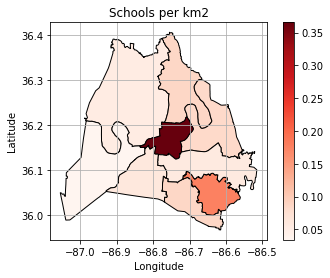

In [69]:
districts_with_counts.plot(
    column = "school_density_per_km2",
    legend = True,
    cmap = "Reds",
    edgecolor = "black"
)

plt.title("Schools per km2")
plt.grid()
plt.xlabel("Longitude")
plt.ylabel("Latitude");

### Choropleth with `folium`

To create an interactive choropleth using `folium`. We have first to create a `folium.Map` then create a `folium.Choropleth` object and add to the map - using `add_to(map)` method. Then 

```python
m = folium.Map(location = [36.1636, -86.7823])

folium.Choropleth(
    geo_data, # the geodataframe or GeoJson file which is the source of the polygons
    name, # the name of geometry column (property) for the ploygons
    data, # the source dataframe or series for the normalized variable
    columns, # a list of columns one corresponds for the polygons and one that has the value to plot
    # ----THE FOLLOWING ARE ADDITIONAL ARGUMENTS----
    key_on = 'feature.properties.district', 
    # `key_on` must be added even if you use GeoDataFrame, Variable in the geo_data GeoJSON file to 
    # bind the data to. Must start with ‘feature’ and be in JavaScript objection notation.
    fill_color, # polygon fill color (color map) (defaults to blue)
    fill_opacity, # 0 ==> trasparent and 1 ==> opaque
    line_color, # color of the border lines (defaults to black)
    line_opacity, # 0 ==> trasparent and 1 ==> opaque
    legend_name # creates a title for the legned
)

display(m)
```

In [70]:
districts_with_counts.head()

,first_name,city,zip,email,state,last_name,address,position,term_expir,district,phone,geometry,schools_count,area_km2,school_density_per_km2
0,Dr. Sharon,Nashville,37218,gentryfordistrict1@comcast.net,TN,Gentry,6108 Beals Lane,Member,2016,1,615-268-5269,"MULTIPOLYGON (((-86.77136 36.38357, -86.77134 ...",30,563.134380,0.053273
1,Jill,Madison,37115,jill.speering@mnps.org,TN,Speering,1033 Falls Avenue,Vice-Chair,2016,3,615-562-5234,"MULTIPOLYGON (((-86.75365 36.40428, -86.75353 ...",19,218.369949,0.087008
2,Dr. Jo Ann,Nashville,37220,joann.brannon@mnps.org,TN,Brannon,5444 San Marcos Drive,Member,2018,2,615-833-5976,"MULTIPOLYGON (((-86.76696 36.08333, -86.76590 ...",11,127.615396,0.086196
3,Anna,Hermitage,37076,anna.shepherd@mnps.org,TN,Shepherd,4545 Raccoon Trail,Chair,2018,4,615-210-3768,"MULTIPOLYGON (((-86.58098 36.20935, -86.58099 ...",18,216.871511,0.082998
4,Amy,Nashville,37221,amy.frogge@mnps.org,TN,Frogge,7237 Riverfront Drive,Member,2016,9,615-521-5650,"MULTIPOLYGON (((-86.97287 36.20828, -86.97045 ...",12,353.232132,0.033972


In [71]:
schools_gpd.head(1)

,School Name,geometry
0,A. Z. Kelley Elementary,POINT (-86.65885 36.02182)


In [73]:
m = folium.Map(location = [36.1636, -86.7823])

folium.Choropleth(
    geo_data = districts_with_counts, # the geodataframe or GeoJson file which is the source of the polygons
    name = "geometry", # the name of geometry column (property) for the ploygons
    data = districts_with_counts, # the source dataframe or series for the normalized variable
    columns = ["district", "school_density_per_km2"], # a list of columns one corresponds for the polygons and one that has the value to plot
    # ----THE FOLLOWING ARE ADDITIONAL ARGUMENTS----
    key_on = 'feature.properties.district', 
    fill_color = "YlGn", # polygon fill color (defaults to blue)
    fill_opacity = 0.75, # 0 ==> trasparent and 1 ==> opaque
    line_color = "black", # color of the border lines (defaults to black)
    line_opacity = 0.5, # 0 ==> trasparent and 1 ==> opaque
    legend_name = "Schools per km squared by School District" # creates a title for the legned
).add_to(m)

# let's add some markers and popups just for fun :)
for index, row in schools_gpd.iterrows():
    center = [row.geometry.centroid.y, row.geometry.centroid.x]
    folium.Marker(location = center, popup = row["School Name"]).add_to(m)

display(m)